In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

In [5]:
df=pd.read_csv('survey.csv')

In [6]:
df_clean = df.copy()
df_clean=df_clean[(df_clean['Age']>=20) & (df_clean['Age']<=90)]

In [7]:
def clean_gender(g):
    g = str(g).strip().lower()
    if g in ['male', 'm', 'man', 'cis male','cis man', 'ostensibly male, unsure what that really means', 'male-ish', 'maile', 'mal', 'male (cis)', 'guy (-ish) ^_^']:
        return 'Male'
    elif g in ['female', 'f', 'woman', 'cis female', 'cis-female/femme', 'female (cis)', '']:
        return 'Female'
    else:
        return 'Other'
df_clean['Gender'] = df_clean['Gender'].apply(clean_gender)

In [8]:
df_clean.drop(['comments', 'state'], axis=1, inplace=True)
df_clean['work_interfere'] = df_clean['work_interfere'].fillna('Unknown')
df_clean['self_employed'] = df_clean['self_employed'].fillna('No')

# Univariate Analysis

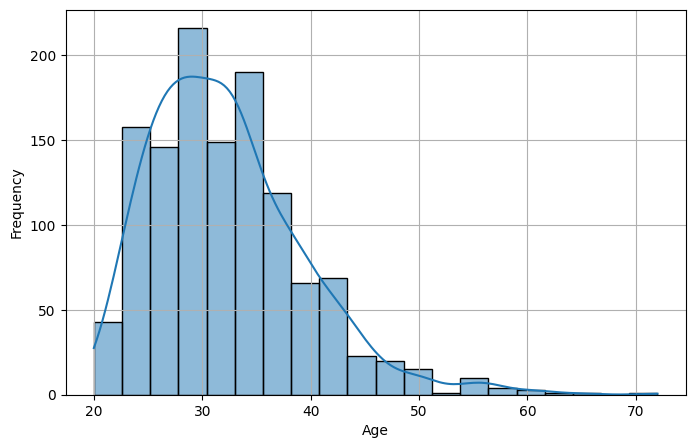

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_clean['Age'], bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: xlabel='treatment', ylabel='count'>

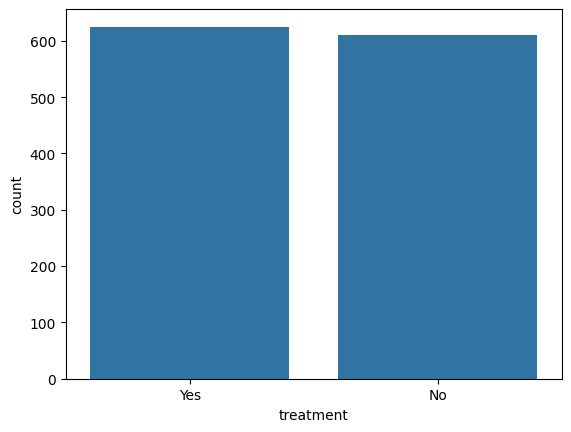

In [10]:
sns.countplot(data=df_clean, x='treatment')

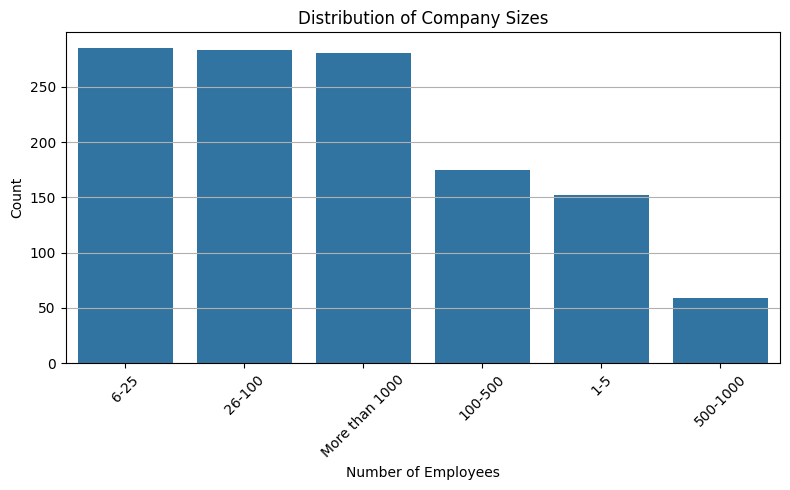

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_clean, x='no_employees', order=df_clean['no_employees'].value_counts().index)

plt.title('Distribution of Company Sizes')
plt.xlabel('Number of Employees')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Bivariate Analysis

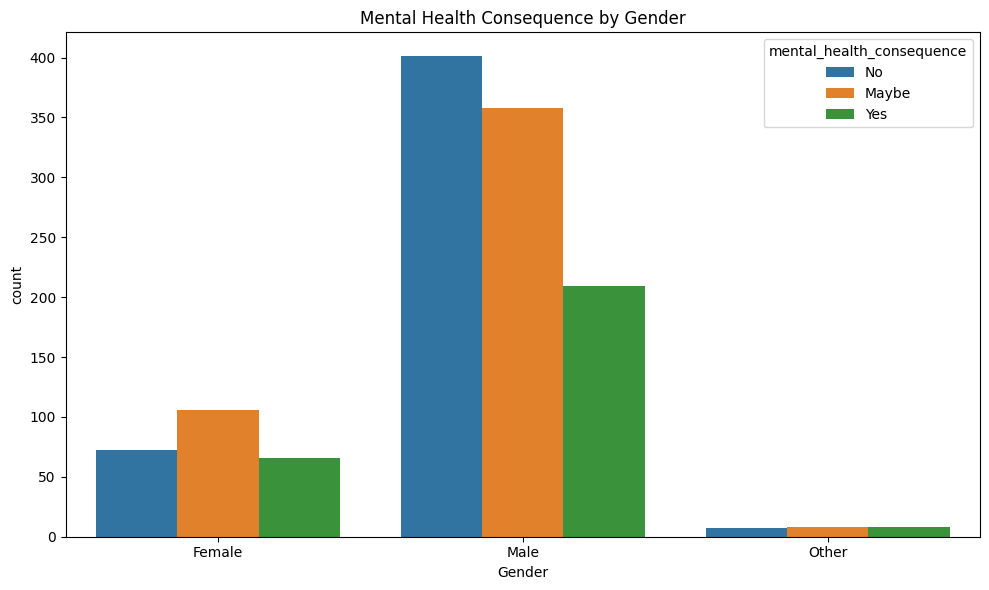

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='Gender', hue='mental_health_consequence')
plt.title('Mental Health Consequence by Gender')
plt.tight_layout()
plt.show()

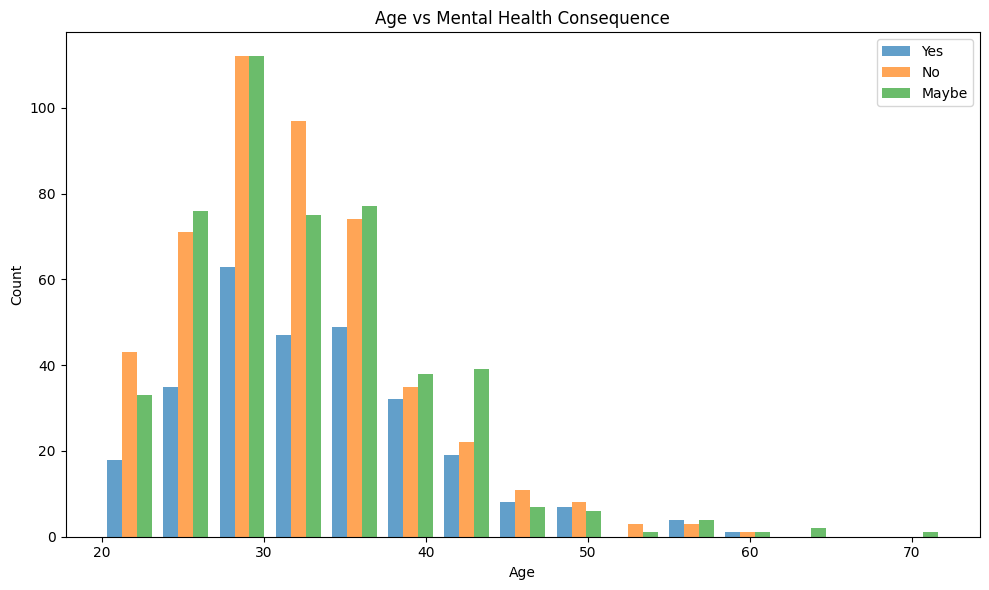

In [14]:
plt.figure(figsize=(10, 6))

plt.hist([
    df_clean[df_clean['mental_health_consequence'] == 'Yes']['Age'],
    df_clean[df_clean['mental_health_consequence'] == 'No']['Age'],
    df_clean[df_clean['mental_health_consequence'] == 'Maybe']['Age']
], bins=15, label=['Yes', 'No', 'Maybe'], alpha=0.7)

plt.title('Age vs Mental Health Consequence')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Multivariate Analysis

In [15]:
# Custom encoding for Gender
gender_map = {'Male': 1, 'Female': 0, 'Other': 0.5}
df_clean['Gender_encoded'] = df_clean['Gender'].map(gender_map)

# Generic function to encode 'Yes' = 1, 'No' = 0, 'Don't know' or 'Maybe' = 0.5
def yes_no_maybe(val):
    val = str(val).strip().lower()
    if val == 'yes':
        return 1
    elif val == 'no':
        return 0
    elif val in ['maybe', "don't know", 'not sure', 'some of them']:
        return 0.5
    else:
        return np.nan  # Leave unknowns as NaN for now

# Apply encoding to multiple columns
columns_to_encode = ['self_employed', 'family_history', 'treatment',
                     'remote_work', 'tech_company',
                     'benefits', 'care_options', 'wellness_program',
                     'seek_help', 'anonymity',
                     'mental_health_consequence', 'phys_health_consequence',
                     'coworkers', 'supervisor', 'mental_health_interview',
                     'phys_health_interview', 'mental_vs_physical',
                     'obs_consequence']

for col in columns_to_encode:
    df_clean[col + '_encoded'] = df_clean[col].apply(yes_no_maybe)
    # Custom mapping for 'work_interfere'
work_interfere_map = {
    'Never': 0,
    'Rarely': 0.25,
    'Sometimes': 0.5,
    'Often': 0.75,
    'Unknown': 0.5   # middle ground for unknowns
}
df_clean['work_interfere_encoded'] = (
    df_clean['work_interfere']
    .str.strip()
    .str.title()
    .map(work_interfere_map)
)
leave_map = {
    "Very easy": 0.2,
    "Somewhat easy": 0.4,
    "Don't know": 0.6,
    "Somewhat difficult": 0.8,
    "Very difficult": 1
}

df_clean['leave_encoded'] = df_clean['leave'].map(leave_map)

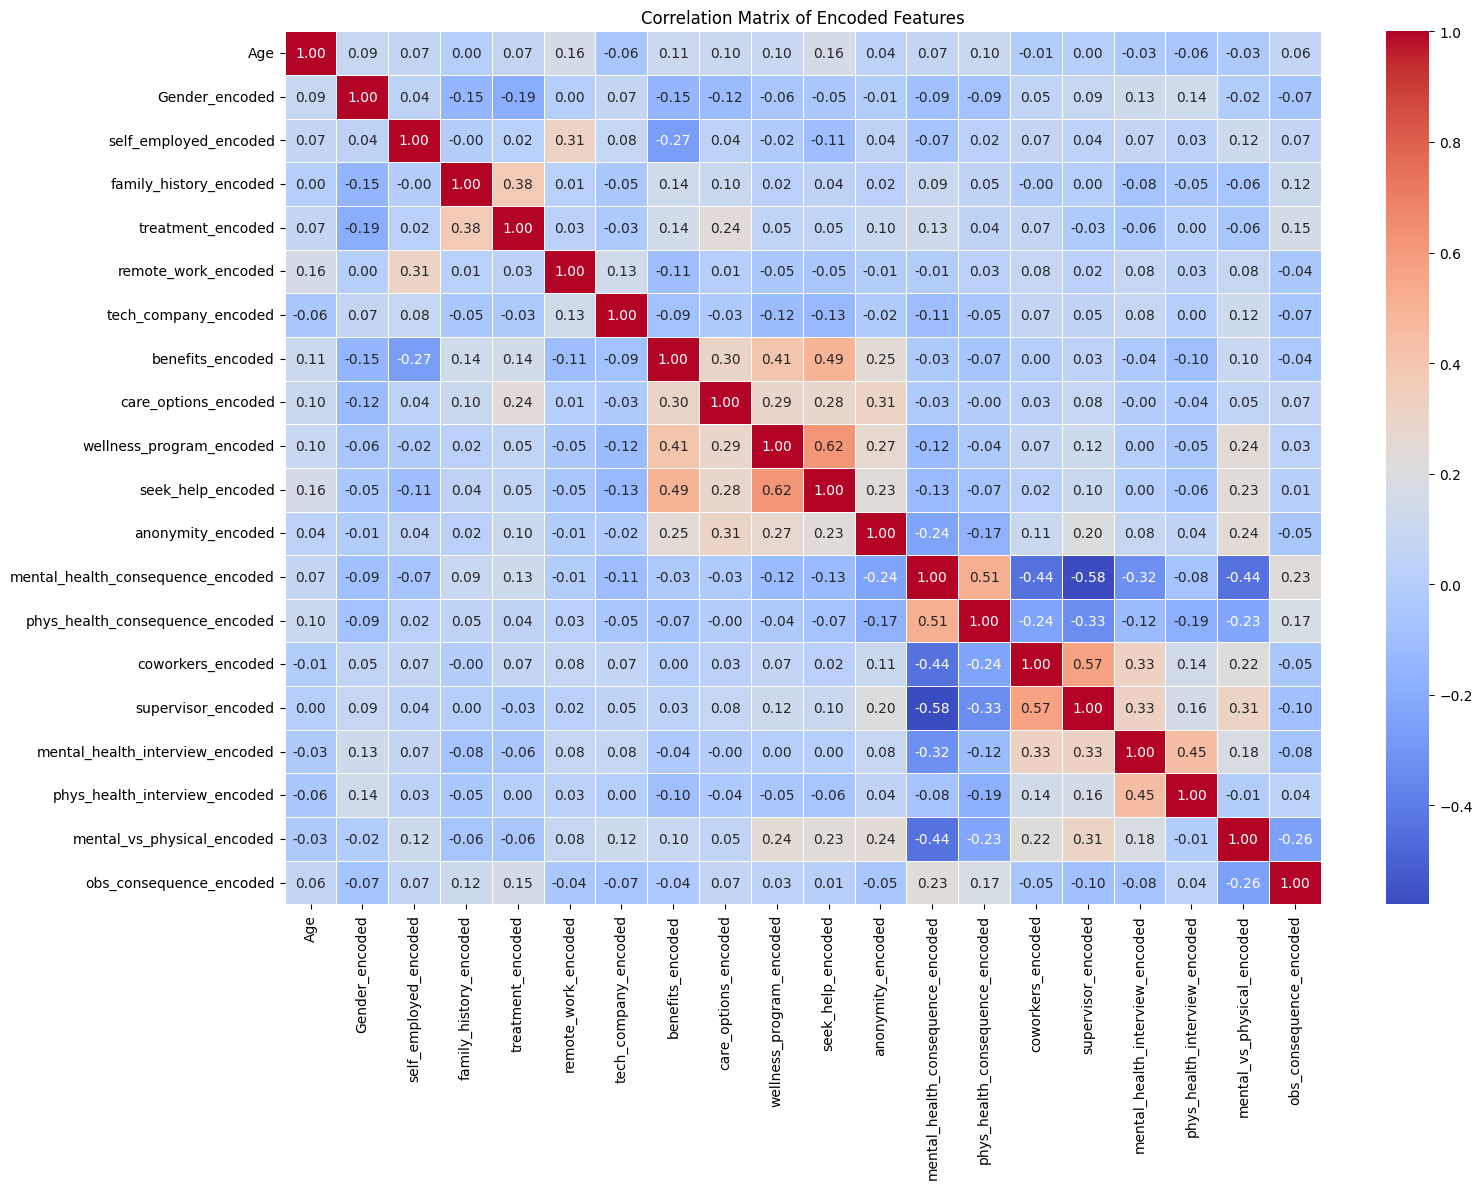

In [18]:
# Select only encoded numeric columns + Age for correlation
encoded_cols = ['Age', 'Gender_encoded'] + [col + '_encoded' for col in columns_to_encode]
df_corr = df_clean[encoded_cols].copy()

# Drop any columns with all NaNs (in case encoding produced only NaNs)
df_corr.dropna(axis=1, how='all', inplace=True)

# Compute correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Encoded Features")
plt.tight_layout()
plt.show()

In [19]:
joblib.dump(df_clean, 'cleaned_data.pkl')

['cleaned_data.pkl']